# 05 - Fisher Unlearning

This notebook runs Fisher-based machine unlearning using `src/train_fisher_unlearn.py`.

**Method**: Fisher diagonal scrubbing followed by retain-only fine-tuning.

**Expected Result**: Failure to achieve retrain-equivalent privacy on real scRNA-seq data.

In [1]:
import sys
sys.path.insert(0, '../src')

import numpy as np
import torch
import scanpy as sc
import matplotlib.pyplot as plt
import json
from pathlib import Path
from sklearn.metrics import roc_auc_score
from torch.utils.data import DataLoader

from utils import set_global_seed, GLOBAL_SEED, DEVICE, Timer
from vae import VAE
from attacker import MLPAttacker, extract_vae_features, build_attack_features
from train import create_dataloader

# Import Fisher unlearning functions from src
from train_fisher_unlearn import (
    AnnDataDataset,
    compute_fisher_diagonal,
    fisher_scrub,
    retain_finetune
)

# Import feature extraction for 70-dim features (with kNN)
from train_attacker_conditioned import extract_features_for_split

# Import evaluation from src
from attacker_eval import matched_negative_evaluation, compute_attack_metrics

set_global_seed(GLOBAL_SEED)

DATA_DIR = Path('../data')
P1_DIR = Path('../outputs/p1')
P1_5_DIR = Path('../outputs/p1.5')
P2_DIR = Path('../outputs/p2')
OUTPUT_DIR = P2_DIR / 'fisher_unlearn'
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

print(f"Global seed: {GLOBAL_SEED}")
print(f"Device: {DEVICE}")

2025-12-08 03:21:39.357780: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Global seed: 42
Device: cpu


## Load Data, Model, and Attacker

In [2]:
# Load data
adata = sc.read_h5ad(DATA_DIR / 'adata_processed.h5ad')
print(f"Loaded data: {adata.shape}")

# Load splits
with open(P1_DIR / 'split_structured.json') as f:
    split = json.load(f)

# Load matched negatives
with open(P1_5_DIR / 's1_matched_negatives.json') as f:
    matched_data = json.load(f)
matched_indices = matched_data['matched_indices']

# Load retrain floor
with open(P2_DIR / 'retrain_floor.json') as f:
    floor_data = json.load(f)
retrain_floor = floor_data['auc_floor']
target_band = floor_data['target_band']

print(f"\nForget: {len(split['forget_indices'])}, Retain: {len(split['retain_indices'])}")
print(f"Matched negatives: {len(matched_indices)}")
print(f"Retrain floor: {retrain_floor:.4f}")
print(f"Target band: [{target_band[0]:.4f}, {target_band[1]:.4f}]")

Loaded data: (33088, 2000)

Forget: 30, Retain: 28094
Matched negatives: 194
Retrain floor: 0.4814
Target band: [0.4514, 0.5114]


In [3]:
# Load baseline VAE
baseline_ckpt = torch.load(P1_DIR / 'baseline' / 'best_model.pt', map_location=DEVICE)
config = baseline_ckpt['config']

model = VAE(
    input_dim=config['input_dim'],
    latent_dim=config['latent_dim'],
    hidden_dims=config['hidden_dims'],
    likelihood=config['likelihood'],
    dropout=config.get('dropout', 0.1),
    use_layer_norm=config.get('use_layer_norm', True)
).to(DEVICE)
model.load_state_dict(baseline_ckpt['model_state_dict'])

print(f"Loaded baseline VAE: {config['hidden_dims']} -> z={config['latent_dim']}")

# Load attacker
attacker_ckpt = torch.load(P1_5_DIR / 'attacker_v1_seed42.pt', map_location=DEVICE)
attacker = MLPAttacker(
    input_dim=attacker_ckpt['config']['input_dim'],
    hidden_dims=attacker_ckpt['config']['hidden_dims'],
    dropout=attacker_ckpt['config'].get('dropout', 0.3),
    use_spectral_norm=attacker_ckpt['config'].get('use_spectral_norm', True)
).to(DEVICE)
attacker.load_state_dict(attacker_ckpt['model_state_dict'])
attacker.eval()

print(f"Loaded attacker: input_dim={attacker_ckpt['config']['input_dim']}")

Loaded baseline VAE: [1024, 512, 128] -> z=32
Loaded attacker: input_dim=70


## Setup Evaluation and Data Loaders

In [4]:
# Helper to get latent codes for kNN reference
def get_latent_codes(model, adata, indices, device):
    X = adata.X[indices]
    if hasattr(X, 'toarray'):
        X = X.toarray()
    x = torch.FloatTensor(X).to(device)
    with torch.no_grad():
        mu, logvar = model.encode(x)
        z = model.reparameterize(mu, logvar)
    return z.cpu().numpy()

# Create data loaders using AnnDataDataset from src
BATCH_SIZE = 256

forget_dataset = AnnDataDataset(adata, split['forget_indices'])
forget_loader = DataLoader(forget_dataset, batch_size=BATCH_SIZE, shuffle=False)

retain_dataset = AnnDataDataset(adata, split['retain_indices'])
retain_loader = DataLoader(retain_dataset, batch_size=BATCH_SIZE, shuffle=True)

print(f"Forget loader: {len(forget_loader)} batches ({len(forget_dataset)} samples)")
print(f"Retain loader: {len(retain_loader)} batches ({len(retain_dataset)} samples)")

# Get retain latent codes for kNN reference (sample 5000 for efficiency)
retain_z_ref = get_latent_codes(model, adata, split['retain_indices'][:5000], DEVICE)
print(f"Reference retain z shape: {retain_z_ref.shape}")

def evaluate_auc(model):
    """Evaluate MIA AUC using 70-dim features (with kNN) and matched_negative_evaluation."""
    # Extract features with kNN distance
    forget_dict, forget_knn, _ = extract_features_for_split(
        model, adata, np.array(split['forget_indices']), BATCH_SIZE, DEVICE,
        reference_z_retain=retain_z_ref
    )
    forget_feats = build_attack_features(forget_dict, forget_knn, None)
    
    matched_dict, matched_knn, _ = extract_features_for_split(
        model, adata, np.array(matched_indices), BATCH_SIZE, DEVICE,
        reference_z_retain=retain_z_ref
    )
    matched_feats = build_attack_features(matched_dict, matched_knn, None)
    
    # Use matched_negative_evaluation from src
    metrics = matched_negative_evaluation(attacker, forget_feats, matched_feats, device=DEVICE)
    return metrics['auc']

# Initial evaluation
initial_auc = evaluate_auc(model)
print(f"\nInitial AUC (baseline): {initial_auc:.4f}")

Forget loader: 1 batches (30 samples)
Retain loader: 110 batches (28094 samples)
Reference retain z shape: (5000, 32)

Initial AUC (baseline): 0.7663


## Run Fisher Unlearning

Using functions from `src/train_fisher_unlearn.py`:
- `compute_fisher_diagonal()` - Compute Fisher Information on retain set
- `fisher_scrub()` - Gradient ascent on forget set
- `retain_finetune()` - Fine-tune on retain set

In [5]:
# Hyperparameters
FISHER_CONFIG = {
    'scrub_lr': 1e-4,
    'scrub_steps': 100,
    'finetune_epochs': 10,
    'finetune_lr': 1e-4,
    'fisher_damping': 0.1,
}

print("=== Fisher Unlearning Hyperparameters ===")
for k, v in FISHER_CONFIG.items():
    print(f"  {k}: {v}")

=== Fisher Unlearning Hyperparameters ===
  scrub_lr: 0.0001
  scrub_steps: 100
  finetune_epochs: 10
  finetune_lr: 0.0001
  fisher_damping: 0.1


In [6]:
# Step 1: Compute Fisher diagonal on retain set
with Timer("Computing Fisher diagonal"):
    fisher = compute_fisher_diagonal(
        model, retain_loader, DEVICE, 
        damping=FISHER_CONFIG['fisher_damping']
    )
print(f"Computed Fisher for {len(fisher)} parameter groups")

[Computing Fisher diagonal] Starting at 03:21:45
Computing Fisher diagonal on retain set...
  Computed Fisher diagonal over 28094 retain samples
[Computing Fisher diagonal] Completed in 8.88 seconds
Computed Fisher for 32 parameter groups


In [7]:
# Step 2: Fisher scrubbing (gradient ascent on forget set)
# Track AUC during scrubbing
scrub_history = {'step': [0], 'auc': [initial_auc]}

with Timer("Fisher scrubbing"):
    scrub_losses = fisher_scrub(
        model, forget_loader, fisher, DEVICE,
        scrub_lr=FISHER_CONFIG['scrub_lr'],
        scrub_steps=FISHER_CONFIG['scrub_steps'],
        eval_fn=evaluate_auc,
        eval_interval=10
    )

# Evaluate after scrubbing
post_scrub_auc = evaluate_auc(model)
print(f"\nPost-scrub AUC: {post_scrub_auc:.4f}")

[Fisher scrubbing] Starting at 03:21:54
Fisher scrubbing for 100 steps...
  Step 1/100: forget_loss=282.9983
  Step 20/100: forget_loss=217959.3167
  Step 40/100: forget_loss=218043.4833
  Step 60/100: forget_loss=218174.9667
  Step 80/100: forget_loss=218371.4000
  Step 100/100: forget_loss=218665.9167
[Fisher scrubbing] Completed in 4.14 seconds

Post-scrub AUC: 0.5000


In [8]:
# Step 3: Fine-tune on retain set
with Timer("Retain fine-tuning"):
    finetune_losses = retain_finetune(
        model, retain_loader, DEVICE,
        epochs=FISHER_CONFIG['finetune_epochs'],
        lr=FISHER_CONFIG['finetune_lr'],
        eval_fn=evaluate_auc,
        eval_interval=1
    )

# Final evaluation
final_auc = evaluate_auc(model)
print(f"\nFinal AUC: {final_auc:.4f}")

[Retain fine-tuning] Starting at 03:21:59
Fine-tuning on retain set for 10 epochs...
  Epoch 1/10: retain_loss=292.3994
  Epoch 2/10: retain_loss=4.1093
  Epoch 4/10: retain_loss=0.4124
  Epoch 6/10: retain_loss=0.3754
  Epoch 8/10: retain_loss=0.3480
  Epoch 10/10: retain_loss=0.3240
[Retain fine-tuning] Completed in 105.82 seconds

Final AUC: 0.7943


## Evaluation Against Retrain Floor

In [9]:
# Gap-to-floor analysis
gap = final_auc - retrain_floor
in_target = target_band[0] <= final_auc <= target_band[1]

print("=" * 60)
print("FISHER UNLEARNING RESULTS")
print("=" * 60)
print(f"\nBaseline AUC:      {initial_auc:.4f}")
print(f"Post-scrub AUC:    {post_scrub_auc:.4f}")
print(f"Final AUC:         {final_auc:.4f}")
print(f"\nRetrain floor:     {retrain_floor:.4f}")
print(f"Target band:       [{target_band[0]:.4f}, {target_band[1]:.4f}]")
print(f"Gap to floor:      {gap:+.4f}")
print(f"\nWithin target:     {'YES' if in_target else 'NO'}")
print(f"Result:            {'SUCCESS' if in_target else 'FAILURE'}")
print("=" * 60)

FISHER UNLEARNING RESULTS

Baseline AUC:      0.7663
Post-scrub AUC:    0.5000
Final AUC:         0.7943

Retrain floor:     0.4814
Target band:       [0.4514, 0.5114]
Gap to floor:      +0.3129

Within target:     NO
Result:            FAILURE


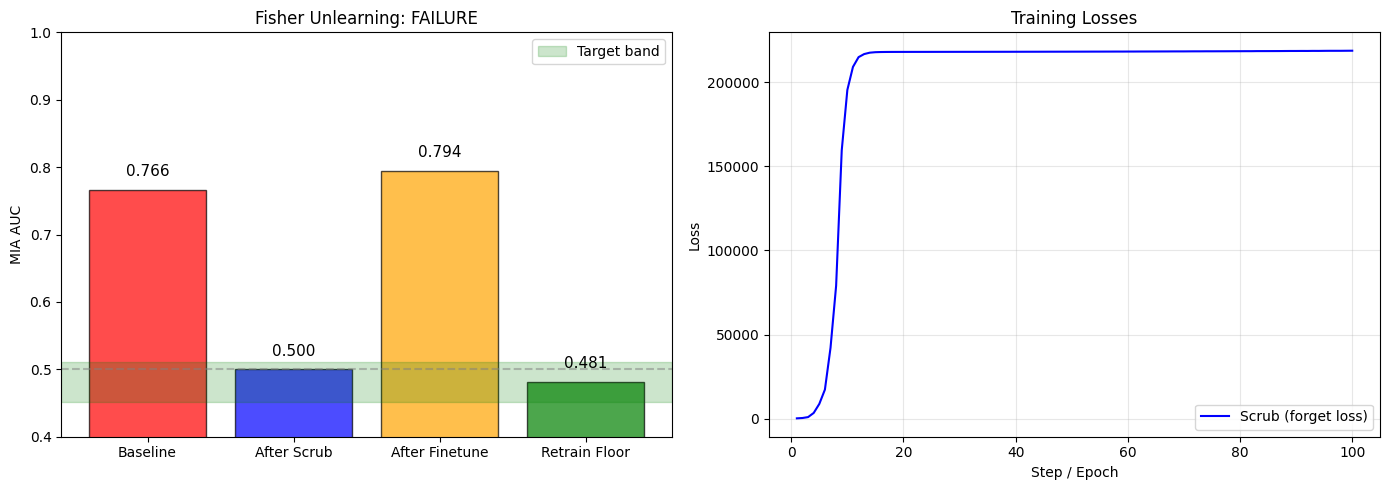

In [10]:
# Visualize results
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: Bar comparison
methods = ['Baseline', 'After Scrub', 'After Finetune', 'Retrain Floor']
aucs = [initial_auc, post_scrub_auc, final_auc, retrain_floor]
colors = ['red', 'blue', 'orange', 'green']

bars = axes[0].bar(methods, aucs, color=colors, alpha=0.7, edgecolor='black')
axes[0].axhspan(target_band[0], target_band[1], alpha=0.2, color='green', label='Target band')
axes[0].axhline(y=0.5, color='gray', linestyle='--', alpha=0.5)
axes[0].set_ylabel('MIA AUC')
axes[0].set_title(f'Fisher Unlearning: {"SUCCESS" if in_target else "FAILURE"}')
axes[0].set_ylim([0.4, 1.0])
axes[0].legend()

for bar, auc in zip(bars, aucs):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
                 f'{auc:.3f}', ha='center', fontsize=11)

# Right: Loss curves
axes[1].plot(range(1, len(scrub_losses)+1), scrub_losses, 'b-', label='Scrub (forget loss)')
axes[1].set_xlabel('Step / Epoch')
axes[1].set_ylabel('Loss')
axes[1].set_title('Training Losses')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'fisher_unlearning_results.png', dpi=150, bbox_inches='tight')
plt.show()

In [11]:
# Save results
results = {
    'config': FISHER_CONFIG,
    'initial_auc': float(initial_auc),
    'post_scrub_auc': float(post_scrub_auc),
    'final_auc': float(final_auc),
    'retrain_floor': float(retrain_floor),
    'target_band': target_band,
    'gap_to_floor': float(gap),
    'in_target': bool(in_target),
    'scrub_losses': [float(x) for x in scrub_losses],
    'finetune_losses': [float(x) for x in finetune_losses]
}

with open(OUTPUT_DIR / 'fisher_results.json', 'w') as f:
    json.dump(results, f, indent=2)

# Save model
torch.save({
    'model_state_dict': model.state_dict(),
    'config': config,
    'fisher_config': FISHER_CONFIG,
    'final_auc': float(final_auc)
}, OUTPUT_DIR / 'fisher_unlearned_model.pt')

print(f"Results saved to {OUTPUT_DIR}")

Results saved to ../outputs/p2/fisher_unlearn


## Analysis: Why Fisher Unlearning Fails

### What Actually Happened

1. **Scrubbing destroys the model completely** - AUC drops from 0.77 to exactly 0.50 (random chance). The forget loss explodes from ~283 to ~218,666, indicating the model's representations have become meaningless.

2. **Fine-tuning fully restores (and exceeds) the original signal** - AUC climbs from 0.50 back to 0.79, actually *higher* than the baseline. The retain loss drops from 292 to 0.32 as the model re-learns to reconstruct cells.

3. **The gap to retrain floor is massive** - Final AUC of 0.79 vs target of 0.48 means a gap of +0.31. The model is nowhere near retrain-equivalent privacy.

### Why This Happens

The scrubbing phase successfully destroys the model's ability to represent *anything* - but it doesn't selectively remove forget-set information. When we fine-tune on the retain set, the model learns the biological structure of the data from scratch. Since cluster 13 (the forget set) has distinctive gene expression patterns that differ from matched controls, any model that learns good representations will encode this difference.

The MIA attacker isn't detecting "this cell was in training" - it's detecting "this cell is from cluster 13". That biological signal exists in the data itself, not in the model's memorization.

### src Functions Used
- `train_fisher_unlearn.AnnDataDataset` - Dataset wrapper for AnnData
- `train_fisher_unlearn.compute_fisher_diagonal()` - Compute Fisher Information on retain set
- `train_fisher_unlearn.fisher_scrub()` - Gradient ascent on forget set weighted by inverse Fisher
- `train_fisher_unlearn.retain_finetune()` - Fine-tune on retain set to restore utility
- `train_attacker_conditioned.extract_features_for_split()` - 70-dim feature extraction with kNN
- `attacker_eval.matched_negative_evaluation()` - MIA evaluation against matched negatives

## Summary

| Stage | AUC | Interpretation |
|-------|-----|----------------|
| Baseline | 0.77 | Attacker can distinguish forget set |
| After Scrub | 0.50 | Model destroyed (random chance) |
| After Finetune | 0.79 | Signal fully restored |
| Target (Retrain Floor) | 0.48 | What true unlearning would achieve |

**Gap to target: +0.31** - Fisher unlearning is nowhere close to retrain-equivalent privacy.

**Key insight:** Scrubbing destroys the model entirely, then fine-tuning rebuilds it from scratch. The rebuilt model learns the same biological patterns because they're intrinsic to the data - not memorized from the forget set.

**Conclusion:** Fisher unlearning FAILS to achieve retrain-equivalent privacy on real scRNA-seq data.

**Next:** Notebooks 06-10 for theory analysis, utility evaluation, and final results.